In this notebook, I will convert other chromosome paintings to check that the results on chr8 is consistent with that

In [1]:
%run ../scripts/notebook_settings_lean.py
from horizonplot import horizonplot

In [2]:
#Functions to generate the stacked area plot df

#Should be easily extendable to multiple paintings by repeating the loop
def length_to_windows(length_df, window_size=100000):
    pops = sorted(length_df["pop"].unique())
    window_l = list(range(length_df.pos.values[0], length_df.end_pos.values[-1], window_size))
    overall_dict = {"windows": window_l}
    for p in pops:
        overall_dict[p] = np.zeros(len(window_l))
    for i in range(len(window_l)):
        w = window_l[i]
        # Finding all paintings that start in this window.
        s_df = length_df.loc[(length_df.pos >= w) & (length_df.pos < w+window_size)]
        for index, row in s_df.iterrows():
            # x decides how many windows it should go beyond the current.
            # if x==0, it both starts and ends in the same window
            x = (row.pos-w+row.paint_length)//window_size
            if x == 0:
                overall_dict[row["pop"]][i] += int(row.paint_length)
            # Otherwise, the current window is filled from row.pos to window end
            else:
                overall_dict[row["pop"]][i] += int((w+window_size)-row.pos)
                # Then iterated for each full window (which is all windows < x)
                for s in range(x-1):
                    overall_dict[row["pop"]][i+1+s] += int(window_size)
                # Then finally added the ending window
                # print(row.paint_length+row.pos, (w+x*window_size), x, w)
                overall_dict[row["pop"]][i+x] += int(row.paint_length+row.pos-(w+x*window_size))
    df = pd.DataFrame(overall_dict)
    return df

def generate_spot_df(single_p_df, map_dict):
    single_p_df["pop"] = single_p_df["paint"].map(map_dict)
    shift_spots = (single_p_df["pop"] != single_p_df["pop"].shift())
    #df based on this subset
    spot_df = single_p_df.loc[shift_spots].copy()
    #Finding the start of the next painting, by removing the first pos and adding the last snp.
    #And then calculating the difference.
    spot_df["paint_length"] = (np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-spot_df["pos"].values)
    spot_df["end_pos"] = (np.append(spot_df["pos"][1:].values, single_p_df.iloc[-1]["pos"])-1)
    return spot_df

def create_paint_df_lengths(paintfile, idfile):
    #various supplemental dataframes/lists
    end_pos = pos_list.values[-1]
    
    map_dict = {}
    for i, row in idfile.iterrows():
        map_dict[row.ID_index*2+1] = row["pop"]
        map_dict[row.ID_index*2+2] = row["pop"]

    df_l = []
    f = open(paintfile, "r")
    ad_lines = f.readlines()
    ind = ""
    hap = ""
    for p_num in range(1, len(ad_lines)):
        l = ad_lines[p_num].strip().split(" ")
        if l[0] == "HAP":
            ind = l[2]
            if hap == 1:
                hap = 2
            else:
                hap = 1
        else:
            paint_line = l[1:]
            single_p_df = pd.DataFrame(data={"pos": pos_list, "paint": paint_line})
            single_p_df = single_p_df.astype(int)
            spot_df = generate_spot_df(single_p_df, map_dict)
            spot_df["individual"] = ind
            spot_df["haplotype"] = hap
            df_l.append(spot_df)
    all_df = pd.concat(df_l)
    return all_df

In [3]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster_females.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
recomb_map_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/chr{}/chr{}.females.recombfile"

os.makedirs("../steps/paint_summary/", exist_ok=True)
chrom_list = [] #["3"] # ["X"]
window_length = 100000
df_l = []
for chrom in chrom_list:
    recomb_map = pd.read_csv(recomb_map_path.format(chrom, chrom), sep=" ")
    pos_list = recomb_map["start.pos"]
    for population in sorted(idfile["pop"].unique()):
        print(population)
        pop_path = "/home/eriks/baboondiversity/people/eriks/baboon_first_analysis/steps/" \
                        "chr{}_8_cluster_large/{}_chr{}_8_cluster_large/chr{}.samples.out"\
                        .format(chrom, population, chrom, chrom)
        length_df = create_paint_df_lengths(pop_path, idfile)
        length_df["chrom"] = chrom
        length_df["C_origin"] = population
        df_l.append(length_df)
#df_lengths = pd.concat(df_l)

In [4]:
#df_lengths.to_csv("../steps/paint_summary/"+"chr3_paint_lengths_8_cluster.txt", sep=" ", index=False)
df_lengths_3 = pd.read_csv("../steps/paint_summary/"+"chr3_paint_lengths_8_cluster.txt", sep=" ")

In [5]:
df_lengths_3

,pos,paint,pop,paint_length,end_pos,individual,haplotype,chrom,C_origin
0,387,89,anubis_tanzania,27150,27536,PD_0721,1,3,anubis_ethiopia
1,27537,80,papio,590,28126,PD_0721,1,3,anubis_ethiopia
2,28127,89,anubis_tanzania,11438,39564,PD_0721,1,3,anubis_ethiopia
3,39565,150,hamadryas,2449,42013,PD_0721,1,3,anubis_ethiopia
4,42014,128,anubis_tanzania,13638,55651,PD_0721,1,3,anubis_ethiopia
...,...,...,...,...,...,...,...,...,...
31497114,181230800,52,cyno_central,29830,181260629,PD_0695,2,3,ursinus
31497115,181260630,191,kindae,10448,181271077,PD_0695,2,3,ursinus
31497116,181271078,167,cyno_central,64245,181335322,PD_0695,2,3,ursinus
31497117,181335323,164,anubis_ethiopia,20,181335342,PD_0695,2,3,ursinus


In [6]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster_females.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")
mapping = {}
c_mapping = {}
for i, row in meta_data_samples.iterrows():
    if row.PGDP_ID[0] != "P":
        mapping["Sci_"+row.PGDP_ID] = row.Origin
        c_mapping["Sci_"+row.PGDP_ID] = row.C_origin
    else:
        mapping[row.PGDP_ID] = row.Origin
        c_mapping[row.PGDP_ID] = row.C_origin
df_lengths_3["population"] = df_lengths_3["individual"].map(mapping)
df_lengths_3["C_origin"] = df_lengths_3["individual"].map(c_mapping)
df_lengths_3["chrom"] = ["chr{}".format(x) if str(x)[0] != "c" else x for x in df_lengths_3.chrom]

In [7]:
id_mapping = {}
for donor in idfile["pop"].unique():
    IDs = idfile.loc[idfile["pop"] == donor].PGDP_ID.unique()
    id_mapping[donor] = meta_data_samples.loc[meta_data_samples.PGDP_ID.isin(IDs)].C_origin.unique()[0]

In [8]:
df_length_stats_3 = df_lengths_3.groupby(["individual", "pop", "C_origin", "chrom"]).sum().reset_index()
df_length_stats_3["Ancestry Counts"] = (df_length_stats_3.groupby(["individual", "pop", "C_origin", "chrom"]).count().reset_index()).paint_length
df_length_stats_3["Mean Fragment"] = (df_length_stats_3.groupby(["individual", "pop", "C_origin", "chrom"]).mean().reset_index()).paint_length

In [9]:
groups = df_length_stats_3.groupby(["individual", "chrom"])
s = groups.transform("sum")
df_length_stats_3["Ancestry Percentage"] = df_length_stats_3["paint_length"]/s["paint_length"]
df_length_stats_3["Fragment Percentage"] = df_length_stats_3["Ancestry Counts"]/s["Ancestry Counts"]
df_length_stats_3["population"] = df_length_stats_3["individual"].map(mapping)
df_length_stats_3["Population, Donor"] = df_length_stats_3["pop"].map(id_mapping)
df_length_stats_3["Population, Recipient"] = df_length_stats_3["individual"].map(c_mapping)
df_length_stats_3 = df_length_stats_3.sort_values(["population", "individual", "pop"])
df_length_stats_3["Ancestry Fragment Ratio"] = df_length_stats_3["Ancestry Percentage"]/df_length_stats_3["Fragment Percentage"]

In [10]:
df_length_stats_8 = pd.read_csv("../results/length_stats_8_cluster.txt")

In [11]:
mycols = sns.color_palette(["#BEE39C", "#1F681F", "#FFE7AF",
                            "#FFD062", "#9EADB2", "#258CC1", "#EA3324", "#C06D34"])
name_order = sorted(df_length_stats_8["Population, Donor"].unique())
color_dir = {}
for i in range(len(name_order)):
    color_dir[name_order[i]] = mycols[i]
# This order of color is based on the alphabetical ordering of the 14 clusters
mycols_cmap = ListedColormap(mycols.as_hex())
mycols

[(0.7450980392156863, 0.8901960784313725, 0.611764705882353),
 (0.12156862745098039, 0.40784313725490196, 0.12156862745098039),
 (1.0, 0.9058823529411765, 0.6862745098039216),
 (1.0, 0.8156862745098039, 0.3843137254901961),
 (0.6196078431372549, 0.6784313725490196, 0.6980392156862745),
 (0.1450980392156863, 0.5490196078431373, 0.7568627450980392),
 (0.9176470588235294, 0.2, 0.1411764705882353),
 (0.7529411764705882, 0.42745098039215684, 0.20392156862745098)]

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


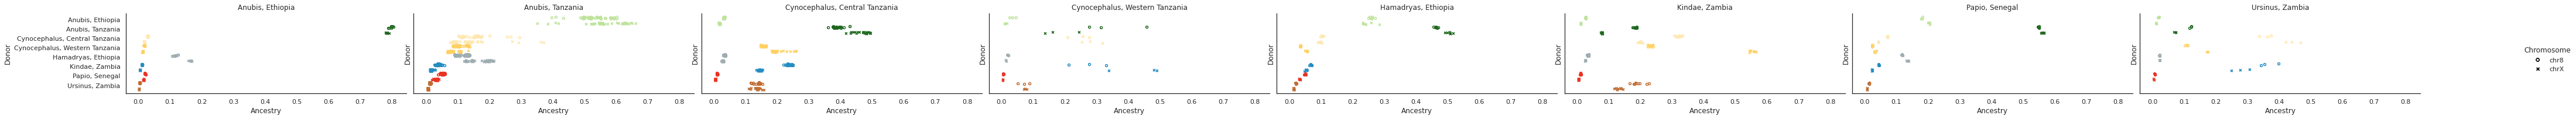

In [12]:
input_data = df_length_stats_8
input_data.chrom = input_data.chrom.astype("category")
input_data["Population, Donor"] = input_data["Population, Donor"].astype("category")

def fun(a, b, markercat, markers, jitter=0.2, dodge=0.3, label=None, data=None, **kwargs):
    offsets = dict((zip(data[markercat].cat.categories, np.linspace(-1, 1, len(data[markercat].cat.categories)))))
    colors = dict(zip(data[b].cat.categories.values, sns.color_palette()))    
    ax = sns.stripplot(x=data[a], y=data[b], 
                       palette=sns.color_palette(['white']),
                      )
    for name, group in data.groupby(b):
        sc = plt.scatter(group[a], np.array(
                        group[b].cat.codes.values) + \
                        jitter*np.random.random(size=len(group[b].cat.codes.values)) + \
                        offsets[label]*dodge, 
                    color=colors[name],
                    marker=markers[label], zorder=10, s=20)

palette_subset = {key: color_dir[key] for key in sorted(input_data["Population, Donor"].unique())}
palette = sns.color_palette(palette_subset.values())
markers = {'chr8':"$\u25EF$", 'chrX':"$\u00D7$"}

with sns.color_palette(palette):
    g = sns.FacetGrid(col="Population, Recipient", hue="chrom", data=input_data,
                      margin_titles=True, legend_out=True, aspect=2.5)
    g.map_dataframe(fun, "Ancestry Percentage", "Population, Donor", 
                    "chrom", markers, data=input_data # hue label and dictionary mapping "hues" to markers are required
                   )
        # nice labels:
    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
    # axix labels and rotated labels (this has to be in a separate for-loop)
    for ax in g.axes.flat:
        ax.set_xlabel('Ancestry')
        ax.set_ylabel('Donor')
        plt.setp(ax.texts, rotation="0")

    # build legend content manually
    label_handles = []
    for label, marker in sorted(markers.items()):
        label_handles.append(matplotlib.lines.Line2D([], [], color='black', 
                                                     marker=marker, linestyle='None',
                                                     # markersize=10, 
                                                     label=label)) 
    # add legend
    g.add_legend(handles=label_handles, title="Chromosome", label_order=["chr8", "chrX"])
plt.savefig("../figures/baboon_ancestry/ancestry_8pop.png", dpi=300, bbox_inches='tight')

In [13]:
df_length_stats_38X = pd.concat([df_length_stats_8, df_length_stats_3])

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


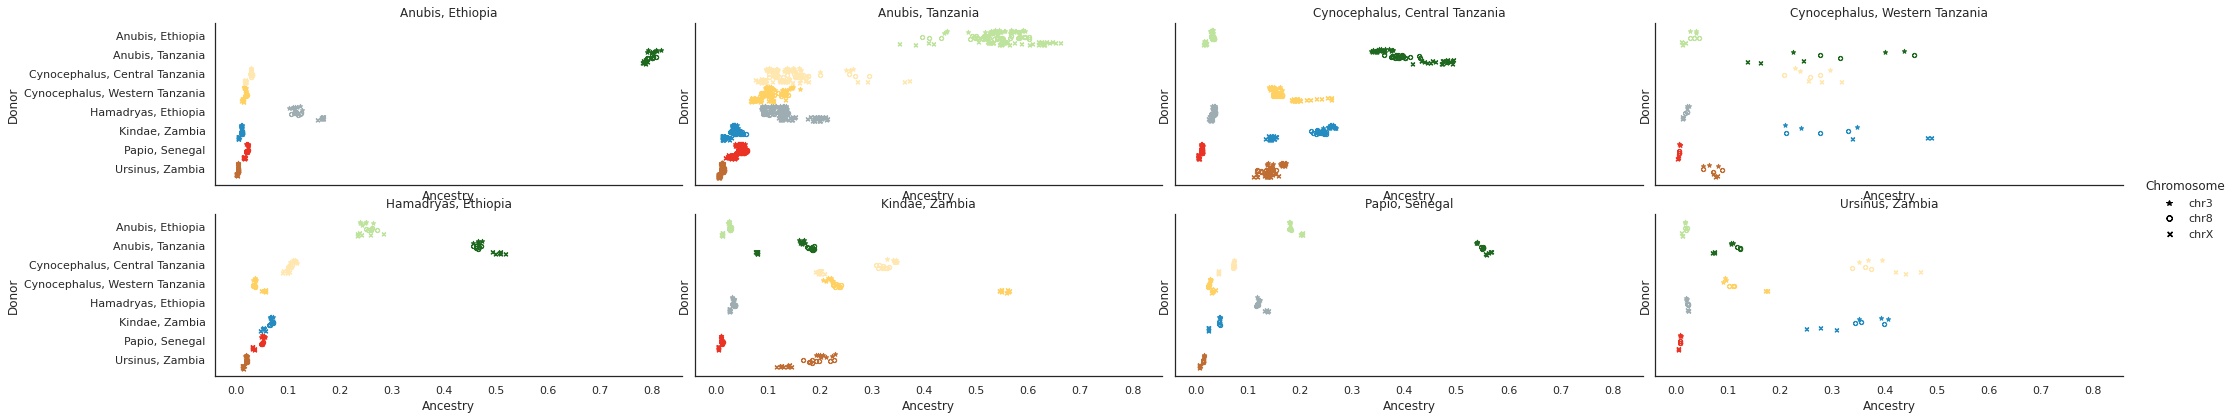

In [14]:
input_data = df_length_stats_38X
input_data.chrom = input_data.chrom.astype("category")
input_data["Population, Donor"] = input_data["Population, Donor"].astype("category")

def fun(a, b, markercat, markers, jitter=0.2, dodge=0.3, label=None, data=None, **kwargs):
    offsets = dict((zip(data[markercat].cat.categories, np.linspace(-1, 1, len(data[markercat].cat.categories)))))
    colors = dict(zip(data[b].cat.categories.values, sns.color_palette()))    
    ax = sns.stripplot(x=data[a], y=data[b], 
                       palette=sns.color_palette(['white']),
                      )
    for name, group in data.groupby(b):
        sc = plt.scatter(group[a], np.array(
                        group[b].cat.codes.values) + \
                        jitter*np.random.random(size=len(group[b].cat.codes.values)) + \
                        offsets[label]*dodge, 
                    color=colors[name],
                    marker=markers[label], zorder=10, s=20)

palette_subset = {key: color_dir[key] for key in sorted(input_data["Population, Donor"].unique())}
palette = sns.color_palette(palette_subset.values())
markers = {'chr3': "*", 'chr8':"$\u25EF$", 'chrX':"$\u00D7$"}

with sns.color_palette(palette):
    g = sns.FacetGrid(col="Population, Recipient", hue="chrom", data=input_data,
                      margin_titles=True, legend_out=True, aspect=2.5, col_wrap=4)
    g.map_dataframe(fun, "Ancestry Percentage", "Population, Donor", 
                    "chrom", markers, data=input_data # hue label and dictionary mapping "hues" to markers are required
                   )
        # nice labels:
    for ax in g.axes.flat:
        plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
        g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
    # axix labels and rotated labels (this has to be in a separate for-loop)
    for ax in g.axes.flat:
        ax.set_xlabel('Ancestry')
        ax.set_ylabel('Donor')
        plt.setp(ax.texts, rotation="0")

    # build legend content manually
    label_handles = []
    for label, marker in sorted(markers.items()):
        label_handles.append(matplotlib.lines.Line2D([], [], color='black', 
                                                     marker=marker, linestyle='None',
                                                     # markersize=10, 
                                                     label=label)) 
    # add legend
    g.add_legend(handles=label_handles, title="Chromosome", label_order=["chr3", "chr8", "chrX"])
plt.savefig("../figures/baboon_ancestry/ancestry_chr3_8pop.png", dpi=300, bbox_inches='tight')

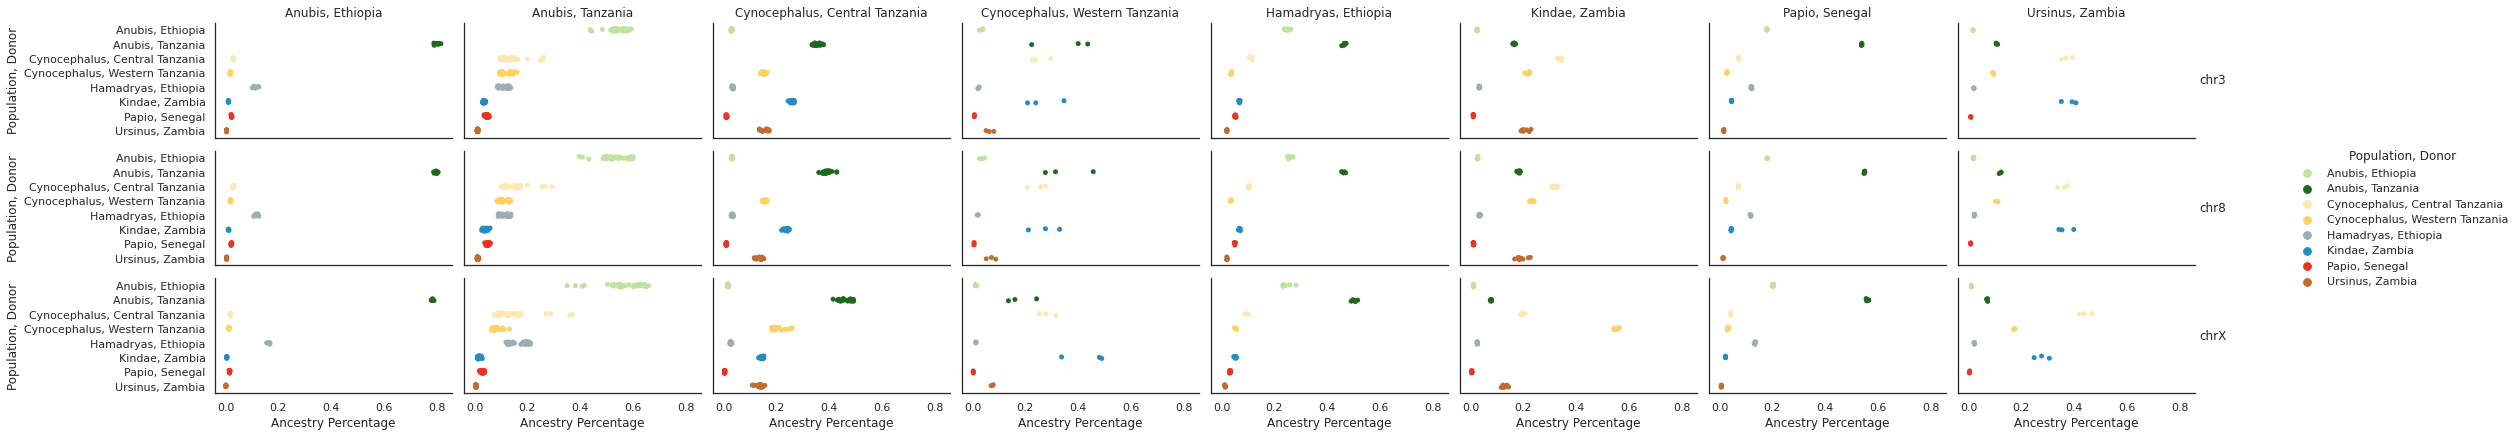

In [36]:
g = sns.catplot(data=df_length_stats_38X, x="Ancestry Percentage", y="Population, Donor", hue="Population, Donor",
                palette=color_dir, kind="strip", height=2, aspect=2, col="Population, Recipient", row="chrom",
                jitter=True, edgecolor="black", order=sorted(df_length_stats_38X["Population, Donor"].unique()),
                margin_titles=True)
for ax in g.axes.flat:
    plt.setp(ax.texts, text="") # remove the original texts, important to do this before setting titles
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
for ax in g.axes.flat:
    plt.setp(ax.texts, rotation="0")
plt.savefig("../figures/baboon_ancestry/ancestry_chr3_split__8pop.pdf", dpi=300, bbox_inches='tight')

In [67]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_14_cluster.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
idfile_14 = idfile.loc[idfile.PGDP_ID.isin(df_length_stats_38X.individual)]
color_14 = sns.color_palette(["#BEE39C", "#88ad00", "#3BAC3B", "#68E068", "#77c458", "#1F681F", "#FFE7AF",
                            "#FFD062", "#FFDE90", "#FFBD00", "#9EADB2", "#258CC1", "#EA3324", "#C06D34"])

name_order = ['Anubis, Ethiopia', 'Anubis, Gombe', 'Anubis, Manyara', 'Anubis, Ngorongoro and Arusha',
       'Anubis, Serengeti', 'Anubis, Tarangire', 'Cynocephalus, Mikumi',
       'Cynocephalus, Ruaha', 'Cynocephalus, Udzungwa and Selous', 'Cynocephalus, Western Tanzania',
              'Hamadryas', 'Kindae, Zambia','Papio, Senegal', 'Ursinus, Zambia']
l_list = sorted(idfile_14["pop"].unique())
dict_14 = {}
color_dir_14 = {}
for i in range(len(l_list)):
    dict_14[l_list[i]] = name_order[i]
    color_dir_14[name_order[i]] = color_14[i]

In [68]:
idfile_14["name_14"] = idfile_14["pop"].map(dict_14)
idfile_14["color"] = idfile_14["name_14"].map(color_dir_14)
cluster_color = pd.Series(idfile_14["color"].values,index=idfile_14["PGDP_ID"]).to_dict()

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


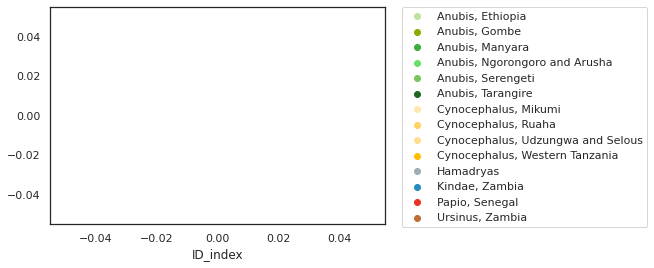

In [69]:
sns.scatterplot(data=idfile_14.sort_values(["name_14"]), x="ID_index", hue="name_14",
                palette=color_dir_14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("../figures/14pop_legend.pdf", dpi=300, bbox_inches='tight')

In [ ]:
sns.scatterplot(data=idfile_14.sort_values(["name_14"]), x="ID_index", hue="name_14",
                palette=color_dir_14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [56]:
idfile_path = "/home/eriks/baboondiversity/data/PG_panu3_phased_chromosomes_4_7_2021/idfile_8_cluster.ids"
idfile = pd.read_csv(idfile_path, sep=" ", names=["PGDP_ID", "pop", "inclusion"])
idfile["ID_index"] = idfile.index
idfile_8 = idfile.loc[idfile.PGDP_ID.isin(df_length_stats_38X.individual)]
color_8 = sns.color_palette(["#BEE39C", "#1F681F", "#FFE7AF",
                            "#FFD062", "#9EADB2", "#258CC1", "#EA3324", "#C06D34"])

name_order = ['Anubis, Ethiopia', 'Anubis, Tanzania',
       'Cynocephalus, Central Tanzania', 'Cynocephalus, Western Tanzania',
       'Hamadryas, Ethiopia', 'Kindae, Zambia', 'Papio, Senegal',
       'Ursinus, Zambia']
l_list = sorted(idfile_8["pop"].unique())
dict_8 = {}
color_dir_8 = {}
for i in range(len(l_list)):
    dict_8[l_list[i]] = name_order[i]
    color_dir_8[name_order[i]] = color_8[i]

In [59]:
idfile_8["name_8"] = idfile_8["pop"].map(dict_8)
idfile_8["color"] = idfile_8["name_8"].map(color_dir_8)
cluster_color = pd.Series(idfile_14["color"].values,index=idfile_14["PGDP_ID"]).to_dict()

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


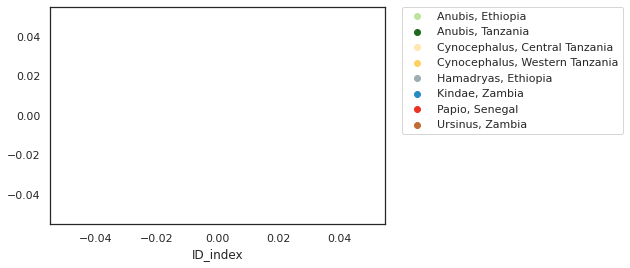

In [63]:
sns.scatterplot(data=idfile_8.sort_values(["name_8"]), x="ID_index", hue="name_8",
                palette=color_dir_8)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("../figures/8pop_legend.pdf", dpi=300, bbox_inches='tight')